In [1]:
import os
import sys
import subprocess
import json
import logging
from concurrent.futures import ThreadPoolExecutor
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision import models

# Define paths
DATASET_ROOT = Path("C:/Users/abhis/Downloads/Documents/Learner Engagement Project/data/DAiSEE/DataSet").resolve()
FRAMES_ROOT = Path("C:/Users/abhis/Downloads/Documents/Learner Engagement Project/data/DAiSEE/ExtractedFrames").resolve()
FRAMES_ROOT.mkdir(parents=True, exist_ok=True)

# Mapping function
def get_csv_clip_id(video_stem: str) -> str:
    base = video_stem.strip()
    if base.startswith("110001"):
        base = base.replace("110001", "202614", 1)
    return base

# Validate dataset
def validate_dataset(directory: Path):
    required_folders = ["Train", "Validation", "Test"]
    for folder in required_folders:
        folder_path = directory / folder
        if not folder_path.exists():
            raise FileNotFoundError(f"Missing dataset split: {folder_path}")
    print(f"Dataset validated at {directory}")

validate_dataset(DATASET_ROOT)

Dataset validated at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\data\DAiSEE\DataSet


### **Extract Frames from Videos**

Convert video files into individual frames for model training. This step is necessary as the DAiSEE dataset contains video clips, and models require image frames.


In [2]:
# Import necessary libraries and modules
import os
import json
import subprocess
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from pathlib import Path

# Frame extraction parameters (no longer using TARGET_FRAMES)
PROCESSED_VIDEOS_FILE = FRAMES_ROOT / "processed_videos.json"

def extract_frames(dataset_root, frames_root, get_csv_clip_id):
    dataset_root = Path(dataset_root)
    frames_root = Path(frames_root)
    processed_videos = set()

    # Load existing processed videos
    if PROCESSED_VIDEOS_FILE.exists():
        with open(PROCESSED_VIDEOS_FILE, "r") as f:
            processed_videos = set(json.load(f))

    total_videos = 0
    videos_to_process = []
    newly_processed = set()

    # Collect all videos to process
    for split in ["Train", "Validation", "Test"]:
        split_dir = dataset_root / split
        if not split_dir.exists():
            continue

        for root, _, files in os.walk(split_dir):
            for file in files:
                if file.lower().endswith(".avi"):
                    total_videos += 1
                    video_path = Path(root) / file
                    video_stem = file.rsplit('.', 1)[0]
                    mapped_id = get_csv_clip_id(video_stem)
                    output_dir = frames_root / split / mapped_id
                    key = f"{split}/{mapped_id}"
                    
                    # Track videos not yet processed
                    if key not in processed_videos:       
                        videos_to_process.append((video_path, output_dir))
                        newly_processed.add(key)

    # Extract frames with progress bar
    # The filter chain does the following:
    # 1. scale=224:224:force_original_aspect_ratio=decrease  resizes while keeping aspect ratio.
    # 2. pad=224:224:(ow-iw)/2:(oh-ih)/2 adds padding to reach 224x224.
    filter_chain = "scale=480:480 :force_original_aspect_ratio=decrease,pad=480:480:(ow-iw)/2:(oh-ih)/2"
    
    with ThreadPoolExecutor() as executor:
        futures = []
        for video_path, output_dir in videos_to_process:
            output_dir.mkdir(parents=True, exist_ok=True)
            cmd = [
                'ffmpeg',
                '-i', str(video_path),
                '-vf', filter_chain,
                str(output_dir / 'frame_%04d.jpg'),
                '-y'
            ]
            futures.append(executor.submit(subprocess.run, cmd, check=True))

        for future in tqdm(futures, total=len(futures), desc="Extracting frames"):
            try:
                future.result()
            except subprocess.CalledProcessError as e:
                print(f"Error extracting frames for {video_path}: {e}")

    # Update processed_videos and save
    processed_videos.update(newly_processed)
    with open(PROCESSED_VIDEOS_FILE, "w") as f:
        json.dump(list(processed_videos), f)

# Execute frame extraction
extract_frames(DATASET_ROOT, FRAMES_ROOT, get_csv_clip_id)

Extracting frames: 100%|██████████| 8231/8231 [58:46<00:00,  2.33it/s]  


## **Verify Label–Frame Alignment**

**Verify Label–Frame Alignment**: This cell verifies that every label in your CSV file has a corresponding extracted frame. It scans each row in the CSV (e.g., _TrainLabels.csv_) and computes the expected frame path. If the frame file does not exist, it logs a warning. Use this cell after dataset validation to ensure your labels and frames are aligned.


In [3]:
import pandas as pd
from pathlib import Path
import logging

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
# (Optional) add a console handler if needed
if not logger.handlers:
    handler = logging.StreamHandler()
    formatter = logging.Formatter("%(levelname)s: %(message)s")
    handler.setFormatter(formatter)
    logger.addHandler(handler)

# Map the CSV clip id to the actual frame folder id.
# Customize this mapping as needed.
def get_csv_clip_id(video_stem: str) -> str:
    base = video_stem.strip()
    if base.startswith("110001"):
        base = base.replace("110001", "202614", 1)
    return base

def verify_label_frame_alignment(csv_path, frames_root):
    """
    Verifies that every label in the CSV has a corresponding first frame file.
    Returns a list of row indices for which the frame is missing.
    """
    df = pd.read_csv(csv_path, dtype=str)
    missing_indices = []
    
    # Determine split from CSV file name. e.g. "TrainLabels.csv" -> "Train"
    split_guess = Path(csv_path).stem.replace("Labels", "").strip()
    
    for idx, row in df.iterrows():
        clip_id = str(row['ClipID']).strip()
        # Remove the .avi extension if present
        if clip_id.endswith('.avi'):
            clip_id = clip_id[:-4]
        
        # Map the clip id to the corresponding frame folder id.
        mapped_id = get_csv_clip_id(clip_id)
        
        # Construct the expected frame path: e.g.
        # frames_root / split_guess / mapped_id / "frame_0001.jpg"
        frame_path = Path(frames_root) / split_guess / mapped_id / "frame_0001.jpg"
        
        if not frame_path.exists():
            logger.warning(f"Missing frame for row {idx}: {frame_path}")
            missing_indices.append(idx)
    
    if missing_indices:
        logger.info(f"Found {len(missing_indices)} rows with missing frames in {split_guess}.")
    else:
        logger.info(f"All labels for {split_guess} have corresponding frames.")
    
    return missing_indices

# Define paths (update these as needed)
DATASET_ROOT = Path("C:/Users/abhis/Downloads/Documents/Learner Engagement Project/data/DAiSEE")
FRAMES_ROOT = DATASET_ROOT / "ExtractedFrames"

# Verify for Train, Validation, and Test
csv_train = DATASET_ROOT / "Labels" / "TrainLabels.csv"
csv_valid = DATASET_ROOT / "Labels" / "ValidationLabels.csv"
csv_test  = DATASET_ROOT / "Labels" / "TestLabels.csv"

missing_train = verify_label_frame_alignment(csv_train, FRAMES_ROOT)
missing_valid = verify_label_frame_alignment(csv_valid, FRAMES_ROOT)
missing_test  = verify_label_frame_alignment(csv_test, FRAMES_ROOT)

INFO: Found 507 rows with missing frames in Train.
INFO: All labels for Validation have corresponding frames.
INFO: Found 146 rows with missing frames in Test.


## **Implement Resume Extraction**

**Implement Resume Extraction:** Instead of deleting partially processed frames, this cell implements a function that checks a video’s output folder and returns the next frame index that needs to be extracted. This allows your extraction script to resume from where it left off rather than starting over.


In [4]:
import logging
from pathlib import Path

# Function to resume frame extraction for a given video.
def resume_extraction_for_video(video_id, split, frames_root, target_frames=15):
    """
    Checks the output folder for a given video and returns the next frame index to extract.
    If the folder doesn't exist, returns 0.
    If some frames exist, returns the count of existing frames.
    
    Parameters:
    - video_id: Unique identifier for the video (e.g., "1100011015").
    - split: The dataset split as a string (e.g., "Train", "Validation", or "Test").
    - frames_root: The root folder where frames are stored.
    - target_frames: The expected number of frames per video.
    
    Returns:
    - The next frame index to be extracted.
    """
    output_folder = Path(frames_root) / split / str(video_id)
    if not output_folder.exists():
        logging.info(f"No folder found for video {video_id} in split {split}. Starting from frame 0.")
        return 0
    existing_frames = list(output_folder.glob("frame_*.jpg"))
    count = len(existing_frames)
    if count < target_frames:
        logging.info(f"Video {video_id} in split {split}: {count} frames found; resuming extraction from frame index {count}.")
    else:
        logging.info(f"Video {video_id} in split {split} already fully processed.")
    return count

# Generalized usage: iterate through each video folder for the splits
splits = ["Train", "Validation", "Test"]
for split in splits:
    split_folder = Path(FRAMES_ROOT) / split
    if not split_folder.exists():
        logging.info(f"Split folder {split_folder} not found.")
        continue
    for video_dir in split_folder.iterdir():
        if video_dir.is_dir():
            video_id = video_dir.name
            next_frame_index = resume_extraction_for_video(video_id, split, FRAMES_ROOT, target_frames=15)
            logging.info(f"Next frame index for video {video_id} in split {split}: {next_frame_index}")

### **Data Transforms**

Define transformations for training (with data augmentation) and validation/testing (without augmentation).


In [5]:
from torchvision import transforms

# Preprocessing transformations for training and validation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

### **Custom Dataset Class**

Create a custom dataset loader to read image paths and labels from text files.


In [6]:
class DAiSEEDataset(Dataset):
    def __init__(self, root, csv_path, transform=None):
        self.root = Path(root)
        self.transform = transform
        self.video_paths = []
        self.labels = []
        self.missing_videos = 0
        self.total_videos = 0

        df = pd.read_csv(csv_path, dtype=str)  # Read all columns as strings
        df.columns = df.columns.str.strip()  # Remove whitespace from column names
        split = Path(csv_path).stem.replace("Labels", "").strip()

        for idx, row in df.iterrows():
            self.total_videos += 1
            try:
                clip_id = row['ClipID'].strip()
                filename = clip_id.split('/')[-1] if '/' in clip_id else clip_id
                video_stem = filename.rsplit('.', 1)[0]
                mapped_id = get_csv_clip_id(video_stem)
                
                print(f"Processing video {video_stem} -> mapped to {mapped_id}")  # Debug print
                
                video_dir = self.root / split / mapped_id
                if not video_dir.exists():
                    print(f"Video directory does not exist: {video_dir}")  # Debug print
                    self.missing_videos += 1
                    continue
                
                frames = list(video_dir.glob('frame_*.jpg'))
                if len(frames) < 15:
                    print(f"Insufficient frames ({len(frames)}) in {video_dir}")  # Debug print
                    self.missing_videos += 1
                    continue
                
                self.video_paths.append(video_dir)
                self.labels.append([
                    row['Boredom'].strip(),
                    row['Engagement'].strip(),
                    row['Confusion'].strip(),
                    row['Frustration'].strip()
                ])
            except Exception as e:
                print(f"Error processing row {idx}: {e}")
        
        if not self.video_paths:
            raise ValueError("No valid videos found")

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_dir = self.video_paths[idx]
        label = [float(val) for val in self.labels[idx]]  # Convert labels to floats
        
        frames = sorted(video_dir.glob('frame_*.jpg'))[:15]
        frame_tensors = []
        for path in frames:
            img = Image.open(path).convert("RGB")
            img = self.transform(img) if self.transform else transforms.ToTensor()(img)
            frame_tensors.append(img)
        
        sequence = torch.stack(frame_tensors)
        label_tensor = torch.tensor(label, dtype=torch.float32)
        return sequence, label_tensor

## **Cache Extracted Data for Faster Reloads**

**Cache Datasets Using joblib:** To avoid reloading and reprocessing the CSV and dataset objects on every execution, this cell caches the dataset objects to a pickle file using joblib. On subsequent runs, the datasets are loaded directly from the cache, greatly reducing startup time. Insert this cell immediately before your DataLoader creation cell.


In [7]:
import joblib
from pathlib import Path
import pandas as pd
import logging
from torch.utils.data import Dataset
from torchvision import transforms
import os

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Now update the caching code.
cache_file = "cached_datasets.pkl"

if Path(cache_file).exists():
    logger.info("Loading cached datasets...")
    datasets = joblib.load(cache_file)
else:
    logger.info("Creating datasets and caching them...")
    datasets = {}
    # The CSV files are now located in the Labels folder under DATASET_ROOT.
    for split_name, transform, csv_name in [
        ("Train", train_transform, "TrainLabels.csv"),
        ("Validation", valid_transform, "ValidationLabels.csv"),
        ("Test", valid_transform, "TestLabels.csv")
    ]:
        csv_path = DATASET_ROOT / "Labels" / csv_name
        dataset = DAiSEEDataset(
            root=FRAMES_ROOT,
            csv_path=csv_path,
            transform=transform
        )
        datasets[split_name] = dataset
        logger.info(f"Missing video directories in {split_name}: {dataset.missing_videos}")
    joblib.dump(datasets, cache_file)
    logger.info("Datasets cached successfully.")

INFO: Creating datasets and caching them...
INFO:__main__:Creating datasets and caching them...


Processing video 1100011002 -> mapped to 2026141002
Processing video 1100011003 -> mapped to 2026141003
Processing video 1100011004 -> mapped to 2026141004
Processing video 1100011005 -> mapped to 2026141005
Processing video 1100011006 -> mapped to 2026141006
Processing video 1100011007 -> mapped to 2026141007
Processing video 1100011008 -> mapped to 2026141008
Processing video 1100011009 -> mapped to 2026141009
Processing video 1100011010 -> mapped to 2026141010
Processing video 1100011011 -> mapped to 2026141011
Processing video 1100011012 -> mapped to 2026141012
Processing video 1100011013 -> mapped to 2026141013
Processing video 1100011014 -> mapped to 2026141014
Processing video 1100011015 -> mapped to 2026141015
Processing video 1100011016 -> mapped to 2026141016
Processing video 1100011017 -> mapped to 2026141017
Processing video 1100011018 -> mapped to 2026141018
Processing video 1100011019 -> mapped to 2026141019
Processing video 1100011020 -> mapped to 2026141020
Processing v

INFO: Missing video directories in Train: 507
INFO:__main__:Missing video directories in Train: 507


Processing video 4599990246 -> mapped to 4599990246
Processing video 4599990247 -> mapped to 4599990247
Processing video 4599990248 -> mapped to 4599990248
Processing video 4599990249 -> mapped to 4599990249
Processing video 459999025 -> mapped to 459999025
Processing video 4000221001 -> mapped to 4000221001
Processing video 4000221002 -> mapped to 4000221002
Processing video 4000221006 -> mapped to 4000221006
Processing video 4000221008 -> mapped to 4000221008
Processing video 4000221009 -> mapped to 4000221009
Processing video 4000221010 -> mapped to 4000221010
Processing video 4000221011 -> mapped to 4000221011
Processing video 4000221013 -> mapped to 4000221013
Processing video 4000221014 -> mapped to 4000221014
Processing video 4000221015 -> mapped to 4000221015
Processing video 4000221016 -> mapped to 4000221016
Processing video 4000221017 -> mapped to 4000221017
Processing video 4000221018 -> mapped to 4000221018
Processing video 4000221024 -> mapped to 4000221024
Processing vid

INFO: Missing video directories in Validation: 0
INFO:__main__:Missing video directories in Validation: 0


Processing video 567496026 -> mapped to 567496026
Processing video 5674960261 -> mapped to 5674960261
Processing video 5674960264 -> mapped to 5674960264
Processing video 5674960268 -> mapped to 5674960268
Processing video 5674960272 -> mapped to 5674960272
Processing video 5674960273 -> mapped to 5674960273
Processing video 5674960274 -> mapped to 5674960274
Processing video 5674960275 -> mapped to 5674960275
Processing video 5674960276 -> mapped to 5674960276
Processing video 5674960277 -> mapped to 5674960277
Processing video 5674960278 -> mapped to 5674960278
Processing video 5674960279 -> mapped to 5674960279
Processing video 567496028 -> mapped to 567496028
Processing video 5674960281 -> mapped to 5674960281
Processing video 5674960282 -> mapped to 5674960282
Processing video 5674960283 -> mapped to 5674960283
Processing video 567496029 -> mapped to 567496029
Processing video 5912920111 -> mapped to 5912920111
Processing video 5912920112 -> mapped to 5912920112
Processing video 5

INFO: Missing video directories in Test: 146
INFO:__main__:Missing video directories in Test: 146


Processing video 987736025 -> mapped to 987736025
Processing video 9877360250 -> mapped to 9877360250
Processing video 9877360252 -> mapped to 9877360252
Processing video 9877360253 -> mapped to 9877360253
Processing video 9877360254 -> mapped to 9877360254
Processing video 9877360256 -> mapped to 9877360256
Processing video 9877360258 -> mapped to 9877360258
Processing video 9877360259 -> mapped to 9877360259
Processing video 9877360261 -> mapped to 9877360261
Processing video 9877360262 -> mapped to 9877360262
Processing video 9877360264 -> mapped to 9877360264
Processing video 987736027 -> mapped to 987736027
Processing video 9877360270 -> mapped to 9877360270
Processing video 9877360271 -> mapped to 9877360271
Processing video 9877360273 -> mapped to 9877360273
Processing video 9877360279 -> mapped to 9877360279
Processing video 987736028 -> mapped to 987736028
Processing video 9877360281 -> mapped to 9877360281
Processing video 987736029 -> mapped to 987736029
Processing video 998

INFO: Datasets cached successfully.
INFO:__main__:Datasets cached successfully.


### Implement Caching & Resume Logic for Faster Reloads

This cell caches preprocessed metadata (e.g., which videos have already been processed and the number of frames extracted) so that if you restart the script, you do not have to reprocess everything from scratch.

The metadata is saved to a file (using joblib) and loaded on subsequent runs. This can greatly speed up reloading if nothing has changed.

Below is the code for caching and resuming metadata.


In [8]:
import joblib
from pathlib import Path

cache_file = "cached_datasets.pkl"

if Path(cache_file).exists():
    logger.info("Loading cached datasets...")
    datasets = joblib.load(cache_file)
else:
    logger.info("Creating datasets and caching them...")
    datasets = {}
    # The CSV files are now located in the Labels folder under DATASET_ROOT.
    for split_name, transform, csv_name in [
        ("Train", train_transform, "TrainLabels.csv"),
        ("Validation", valid_transform, "ValidationLabels.csv"),
        ("Test", valid_transform, "TestLabels.csv")
    ]:
        csv_path = DATASET_ROOT / "Labels" / csv_name
        dataset = DAiSEEDataset(
            root=FRAMES_ROOT,
            csv_path=csv_path,
            transform=transform
        )
        datasets[split_name] = dataset
        logger.info(f"Total videos in {split_name}: {dataset.total_videos}")
        logger.info(f"Missing video directories in {split_name}: {dataset.missing_videos}")
    joblib.dump(datasets, cache_file)
    logger.info("Datasets cached successfully.")

INFO: Loading cached datasets...
INFO:__main__:Loading cached datasets...


###  **Load Labels and Create DataLoaders**

Generate new labels files pointing to extracted frames and set up PyTorch DataLoaders.


In [9]:
def get_dataloaders(dataset_root):
    labels_path = dataset_root / "Labels"
    
    datasets = {
        "Train": DAiSEEDataset(FRAMES_ROOT, labels_path / "TrainLabels.csv", transform=train_transform),
        "Validation": DAiSEEDataset(FRAMES_ROOT, labels_path / "ValidationLabels.csv", transform=valid_transform),
        "Test": DAiSEEDataset(FRAMES_ROOT, labels_path / "TestLabels.csv", transform=valid_transform)
    }

    dataloaders = {}
    batch_size = 16
    num_workers = 0  # Use 0 for Windows

    for split, dataset in datasets.items():
        dataloaders[split] = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=True if split == "Train" else False,
            num_workers=num_workers,
            pin_memory=True
        )
    
    return dataloaders

print("Creating data loaders...")
dataloaders = get_dataloaders(DATASET_ROOT)

Creating data loaders...
Processing video 1100011002 -> mapped to 2026141002
Processing video 1100011003 -> mapped to 2026141003
Processing video 1100011004 -> mapped to 2026141004
Processing video 1100011005 -> mapped to 2026141005
Processing video 1100011006 -> mapped to 2026141006
Processing video 1100011007 -> mapped to 2026141007
Processing video 1100011008 -> mapped to 2026141008
Processing video 1100011009 -> mapped to 2026141009
Processing video 1100011010 -> mapped to 2026141010
Processing video 1100011011 -> mapped to 2026141011
Processing video 1100011012 -> mapped to 2026141012
Processing video 1100011013 -> mapped to 2026141013
Processing video 1100011014 -> mapped to 2026141014
Processing video 1100011015 -> mapped to 2026141015
Processing video 1100011016 -> mapped to 2026141016
Processing video 1100011017 -> mapped to 2026141017
Processing video 1100011018 -> mapped to 2026141018
Processing video 1100011019 -> mapped to 2026141019
Processing video 1100011020 -> mapped t

**Optimize DataLoader Performance:** In this cell, we modify the DataLoader settings to optimize performance based on your operating system.

- On **Windows**, we set NUM_WORKERS = 0 to avoid multiprocessing issues.
- On **Linux/Mac**, we set NUM_WORKERS to one less than the total CPU cores.We also use persistent_workers only when multiple workers are in use.


### **Visualize Sample Data**

Check preprocessing by visualizing a batch of images with their labels.


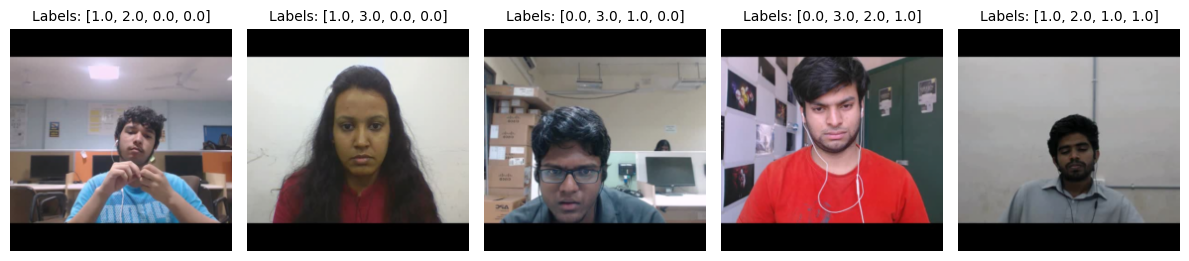

In [16]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

def display_samples(data_loader, n_samples=5):
    """Display a grid of sample images with engagement labels."""
    try:
        images, labels = next(iter(data_loader))  # Get a batch
    except StopIteration:
        print("No data to display.")
        return

    # Inverse transform to convert images back to displayable format
    inv_trans = transforms.Compose([
        transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                             std=[1/0.229, 1/0.224, 1/0.225]),
    ])

    plt.figure(figsize=(12, 4))
    for i in range(min(n_samples, len(images))):
        # Apply inverse normalization
        img = inv_trans(images[i])
        # If the returned tensor is sparse, convert it to a dense tensor
        if img.is_sparse:
            img = img.to_dense()
        # Remove extra dimensions
        img = img.squeeze()
        # If still 4D, remove the extra dimension
        if img.dim() == 4:
            img = img[0]
        # Convert from [C, H, W] to [H, W, C] for display
        img = img.permute(1, 2, 0).clamp(0, 1)

        plt.subplot(1, n_samples, i + 1)
        plt.imshow(img.numpy())
        plt.title(f"Labels: {labels[i].tolist()}", fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Display sample images from the training set using the "Train" loader.
display_samples(dataloaders["Train"], n_samples=5)

##### getting an overview of the structure and contents of the loaded datasets.


In [11]:
import joblib

# Path to the cached file
cache_file = "cached_datasets.pkl"

# Load the cached datasets
datasets = joblib.load(cache_file)

# Inspect the contents of the datasets
for split_name, dataset in datasets.items():
    print(f"Split: {split_name}")
    print(f"Number of video paths: {len(dataset.video_paths)}")
    print(f"Number of labels: {len(dataset.labels)}")
    print(f"First video path: {dataset.video_paths[0] if dataset.video_paths else 'None'}")
    print(f"First label: {dataset.labels[0] if dataset.labels else 'None'}")


Split: Train
Number of video paths: 4851
Number of labels: 4851
First video path: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\data\DAiSEE\ExtractedFrames\Train\2026141002
First label: ['0', '2', '0', '0']
Split: Validation
Number of video paths: 1429
Number of labels: 1429
First video path: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\data\DAiSEE\ExtractedFrames\Validation\4000221001
First label: ['0', '2', '0', '0']
Split: Test
Number of video paths: 1638
Number of labels: 1638
First video path: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\data\DAiSEE\ExtractedFrames\Test\5000441001
First label: ['1', '2', '0', '0']


### **Save preprocessed data**


In [12]:
import os
import torch

# Save preprocessed data
torch.save(datasets["Train"], os.path.join(str(FRAMES_ROOT), "train_set.pth"))
torch.save(datasets["Validation"], os.path.join(str(FRAMES_ROOT), "val_set.pth"))
torch.save(datasets["Test"], os.path.join(str(FRAMES_ROOT), "test_set.pth"))

##### Load and verify the saved datasets


In [13]:
import os
import torch

# Load all datasets with weights_only=False
train_set = torch.load(
    os.path.join(str(FRAMES_ROOT), "train_set.pth"),
    weights_only=False
)
validation_set = torch.load(
    os.path.join(str(FRAMES_ROOT), "val_set.pth"),
    weights_only=False
)
test_set = torch.load(
    os.path.join(str(FRAMES_ROOT), "test_set.pth"),
    weights_only=False
)

# Display the loaded datasets
print(f"Train set loaded: {len(train_set)} samples")
print(f"Validation set loaded: {len(validation_set)} samples")
print(f"Test set loaded: {len(test_set)} samples")

Train set loaded: 4851 samples
Validation set loaded: 1429 samples
Test set loaded: 1638 samples
